In [1]:
import cv2
import numpy as np
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, concatenate, Dropout,
                                     AveragePooling2D, AveragePooling3D, MaxPooling3D)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile
from tqdm.notebook import tqdm
import itertools

In [2]:
SEED = 42
from numpy.random import seed
from tensorflow import random
seed(SEED)
random.set_seed(SEED)

In [3]:
X = np.load('../project1/X.npy')
Y = np.load('../project1/Y.npy')

In [4]:
X.shape

(2062, 64, 64)

In [5]:
X = np.stack(3*[X],axis=3)

In [6]:
X.shape, Y.shape

((2062, 64, 64, 3), (2062, 10))

In [7]:
Ydf = DataFrame(data=Y, columns=[9,0,7,6,1,8,4,3,2,5])
Ydf = Ydf[[x for x in range(10)]].to_numpy()
X_train, X_valid, y_train, y_valid = train_test_split(X, Ydf, test_size=0.1, random_state=SEED)
Ydf.shape, X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2062, 10), (1855, 64, 64, 3), (207, 64, 64, 3), (1855, 10), (207, 10))

In [8]:
train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1,
                                   width_shift_range=4, height_shift_range=4)
train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=50,
        shuffle=False,
        seed=SEED)

In [9]:
valid_datagen = ImageDataGenerator()
valid_generator = valid_datagen.flow(
        X_valid, y_valid,
        batch_size=50,
        shuffle=False,
        seed=SEED)

In [10]:
input_shape = (64,64)

In [11]:
def create_pretrained_model(input_shape):
    
    model = DenseNet121(include_top=False, input_shape=input_shape)
    output = model.get_layer('pool4_pool').output
    #output = MaxPooling2D(pool_size=(2,2))(output)

    
#     model = VGG16(include_top=False, input_shape=input_shape)
#     output = model.layers[-1].output
#     output = AveragePooling2D(pool_size=(3,3))(output)
    
    output = Flatten()(output)
    
    model = Model(model.input, output)
    
    #model.trainable = False
    for layer in model.layers:
        layer.trainable = False
    return model

In [12]:
model = create_pretrained_model((input_shape[0],input_shape[1],3))

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [14]:
def get_features(model, datagen, multiplier=1):
    nb_samples = datagen.n
    
    nb_batches = multiplier * (1 + ((nb_samples-1)//datagen.batch_size))
    
    y_list = []
    feature_list = [] 
    
    for batch in tqdm(range(nb_batches)):
        x_batch, y_batch = datagen.next()
        y_batch_pred = model.predict(x_batch)
        
        feature_list.append(y_batch_pred)
        y_list.append(y_batch)

    highlvl_features = np.concatenate(feature_list)
    y = np.concatenate(y_list)
#     highlvl_features = model.predict_generator(datagen, nb_samples*multiplier)
    
#     bacth_size_old = datagen.batch_size
#     datagen.batch_size = nb_samples
#     y = train_generator.next()[1]
#     y = np.tile(y,multiplier)
#     datagen.batch_size = bacth_size_old
    
    return highlvl_features, y

In [15]:
features_train_file = 'TL-features-train.npy'
features_valid_file = 'TL-features-valid.npy'
y_train_file = 'TL-y-train.npy'
y_valid_file = 'TL-y-valid.npy'

In [16]:
if isfile(features_train_file):
    features_train = np.load(features_train_file, allow_pickle=True)
    features_valid = np.load(features_valid_file, allow_pickle=True)
    y_train = np.load(y_train_file, allow_pickle=True)
    y_valid = np.load(y_valid_file, allow_pickle=True)
else:
    features_train, y_train = get_features(model, train_generator, 20)
    features_valid, y_valid = get_features(model, valid_generator)
    
    np.save(features_train_file, features_train, allow_pickle=True)
    np.save(features_valid_file, features_valid, allow_pickle=True)
    np.save(y_train_file, y_train, allow_pickle=True)
    np.save(y_valid_file, y_valid, allow_pickle=True)

In [17]:
def create_toplvl_model(input_shape):
    return Sequential([
        Input(shape=input_shape),
        
        Dropout(0.2),
        
        Dense(128),
        Activation('relu'),
        Dropout(0.1),
        Dense(64),
        Activation('relu'),
        Dropout(0.1),
        Dense(32),
        Activation('relu'),
        Dropout(0.1),
        Dense(10),
        Activation('softmax')
])

In [18]:
features_train.shape, y_train.shape, features_valid.shape, y_valid.shape

((37100, 2048), (37100, 10), (207, 2048), (207, 10))

In [19]:
toplvl_input_shape = model.output_shape[1]
top_model = create_toplvl_model(toplvl_input_shape)
toplvl_input_shape

2048

In [20]:
loss='categorical_crossentropy'
#LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 30
                             
#model.compile(loss=loss, optimizer='adamax', metrics=[root_mean_squared_error])
top_model.compile(loss=loss, batch_size=BATCH_SIZE, optimizer='nadam', metrics=['acc'])

In [21]:
history = top_model.fit(x=features_train, y=y_train, epochs=EPOCHS, validation_data=(features_valid, y_valid),
                    verbose=1)

Train on 37100 samples, validate on 207 samples
Epoch 1/30
37100/37100 [==============================] - 7s 193us/sample - loss: 0.3629 - acc: 0.8781 - val_loss: 0.1546 - val_acc: 0.9469
Epoch 2/30
37100/37100 [==============================] - 5s 147us/sample - loss: 0.1146 - acc: 0.9632 - val_loss: 0.0685 - val_acc: 0.9855
Epoch 3/30
37100/37100 [==============================] - 6s 151us/sample - loss: 0.0841 - acc: 0.9727 - val_loss: 0.1016 - val_acc: 0.9758
Epoch 4/30
37100/37100 [==============================] - 6s 151us/sample - loss: 0.0690 - acc: 0.9779 - val_loss: 0.0912 - val_acc: 0.9807
Epoch 5/30
37100/37100 [==============================] - 6s 151us/sample - loss: 0.0586 - acc: 0.9815 - val_loss: 0.0524 - val_acc: 0.9807
Epoch 6/30
37100/37100 [==============================] - 6s 150us/sample - loss: 0.0558 - acc: 0.9818 - val_loss: 0.0513 - val_acc: 0.9807
Epoch 7/30
37100/37100 [==============================] - 5s 141us/sample - loss: 0.0497 - acc: 0.9846 - val_los

In [22]:
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = plt.subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        plt.grid(True)
        plt.xlabel('epoch')
    plt.show()

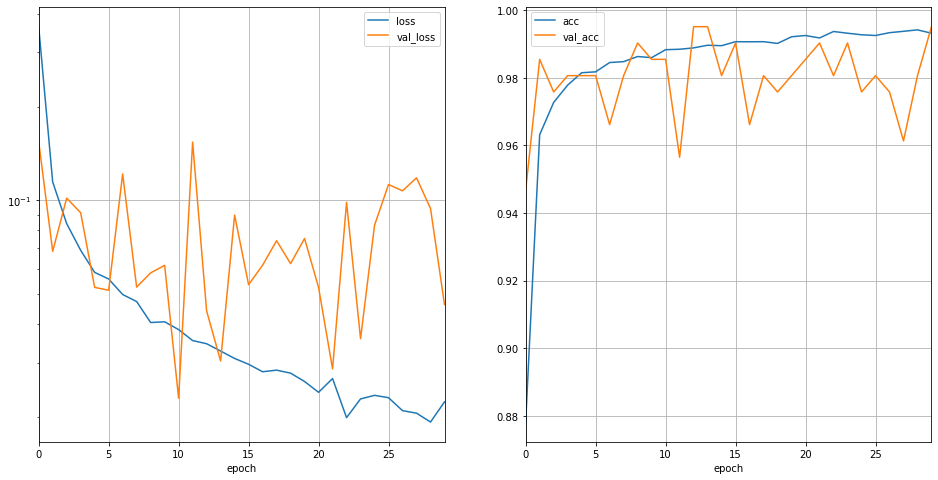

In [23]:
fig = plt.figure(figsize=(16, 8))
plot_history(history, metrics=['loss','acc'], val=True, logy=[True,False])

In [24]:
y_pred = top_model.predict(features_valid)

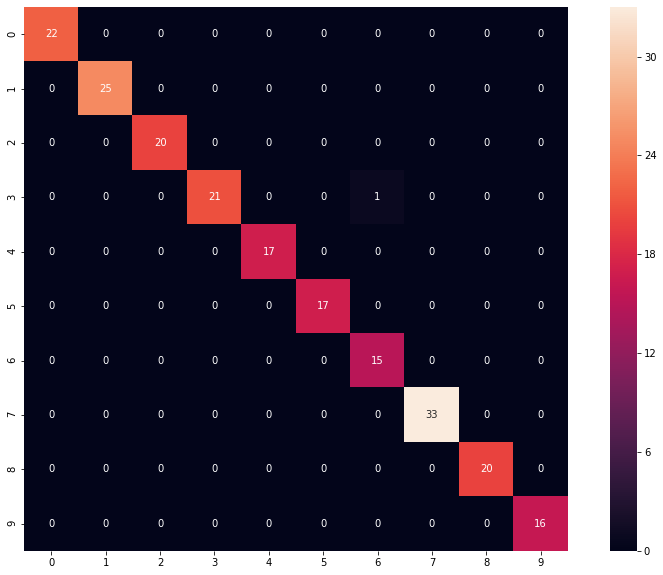

Accuracy= 0.9951690821256038


In [25]:
y_valid_class = y_valid.argmax(axis=1)
y_valid_pred_class = y_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_valid_class, y_valid_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_valid_class, y_valid_pred_class))

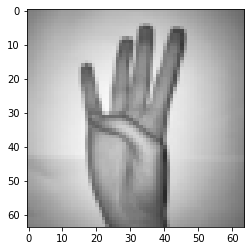

[3]


In [26]:
errors = X_valid[y_valid_class != y_valid_pred_class]
for i, img in enumerate(errors):
    plt.subplot(1, errors.shape[0], i+1)
    plt.imshow(img)
plt.show()
print(y_valid[y_valid_class != y_valid_pred_class].argmax(axis=1))

In [27]:
errors.shape

(1, 64, 64, 3)

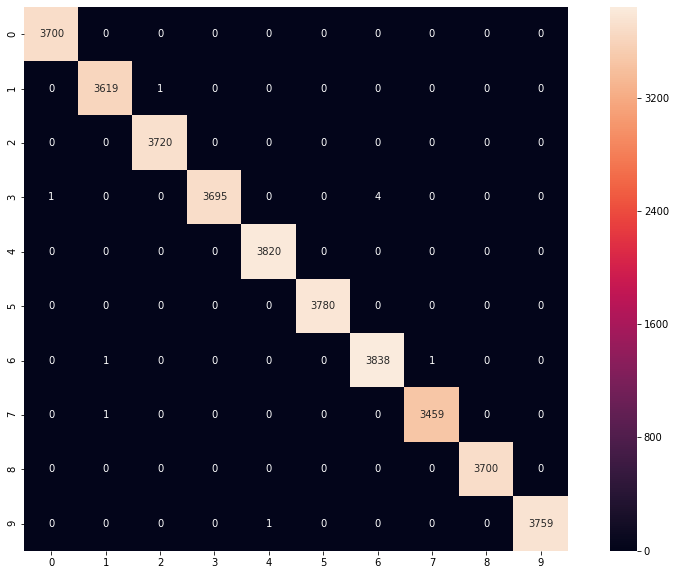

Accuracy= 0.9997304582210242


In [28]:
y_train_pred = top_model.predict(features_train)
y_train_class = y_train.argmax(axis=1)
y_train_pred_class = y_train_pred.argmax(axis=1)
conf_mat = confusion_matrix(y_train_class, y_train_pred_class)
plt.figure(figsize=(15,10))
sns.heatmap(conf_mat,square=True, annot=True, fmt='.0f')
plt.show()
print('Accuracy=', accuracy_score(y_train_class, y_train_pred_class))